A note book for documenting qualitative results

In [1]:
import os
import matplotlib.pyplot as plt
import torchvision
import torch
import pandas as pd
import numpy as np

from models import get_inception_transform
from data_loaders import CUB_extnded_dataset,CUB_CtoY_dataset
from IPython.display import display
from utils.notebook import display_scrollable_dataframe,plot_sailency
from sailency import get_saliency_maps,saliency_score_part

c:\Users\Andre\anaconda3\envs\CBM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Settings for the experiment your running
data_set = 'test' 

#Make the dataset
transform = get_inception_transform(mode=data_set, methode= "center")

majority_config = {'CUB_dir':r'data/CUB_200_2011',
                'split_file':r'data/train_test_val.pkl',
                'use_majority_voting':True,
                'min_class_count':0,
                'return_visibility':False}

NoN_majority_config = {'CUB_dir':r'data/CUB_200_2011',
                'split_file':r'data/train_test_val.pkl',
                'use_majority_voting':False,
                'min_class_count':0,
                'return_visibility':False}

Non_majority_data_set = CUB_extnded_dataset(mode=data_set,config_dict=NoN_majority_config,transform=transform)



#Make the majority dataset and find the mask, we use CtoY dataset so we only need to loade the image ones 
Majority_dataset = CUB_CtoY_dataset(mode=data_set,config_dict=majority_config,transform=transform)
mask = Majority_dataset.concept_mask

#Make dataloader that return non standarized images
human_tansform = torchvision.transforms.Compose([torchvision.transforms.CenterCrop(299),torchvision.transforms.ToTensor()])
data_human = CUB_extnded_dataset(mode=data_set,config_dict=majority_config,transform=human_tansform)

#Define usefull variables
concept_names = data_human.consept_labels_names
class_names = data_human.class_labels_names
n_classes = data_human.n_classes
n_concepts = data_human.n_concepts

print(f"Number of classes: {n_classes}")
print(f"Number of concepts: {n_concepts}")

Number of classes: 200
Number of concepts: 312


In [3]:
#Find all idx for a class
class_id = 86

class_list = []
for i in range(len(Majority_dataset)):
    C,Y = Majority_dataset.__getitem__(i)
    Y = torch.argmax(Y)
    if Y == class_id:
        class_list.append(i)
print(class_list)





[2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466, 2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474]


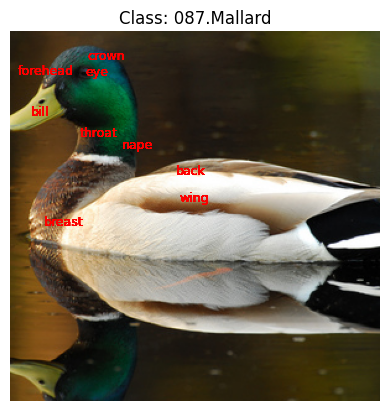

In [19]:
# Genrate the dataset
#picturer_idx = 2455
picturer_idx = 2463
#picturer_idx = 2454 #Gadwell

img ,_,Y,coordinates = data_human.__getitem__(picturer_idx)

# Show the image and the coordinates of the concepts
plt.imshow(img.permute(1, 2, 0))
plt.title(f"Class: {class_names[torch.argmax(Y)]}")
for i in range(len(coordinates)):
    if len(coordinates[i]) > 0:

        for x,y in coordinates[i]:
            #plt.plot(x,y,'ro')
            name=concept_names[i].split("_")[1]
            if name == "forehead":
                ofset = -30

            elif name == "eye":
                ofset = 0
            else:
                ofset = 0
            
            plt.text(x+ofset,y,name,fontsize=9,color='red')
    plt.axis('off')
            
plt.size=(50,50)
plt.show()

#Load the data
_, C, Y,_ = Non_majority_data_set.__getitem__(picturer_idx)

# Separate the concepts and their visibility only relevant if visibility is used and no majority voting is used
if len(C.shape) == 2:
    Concepts = C[0]
    Concepts_visiblity = C[1]
else:
    Concepts = C.tolist()
    Concepts_visiblity = [None]*len(C)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25..0.25].


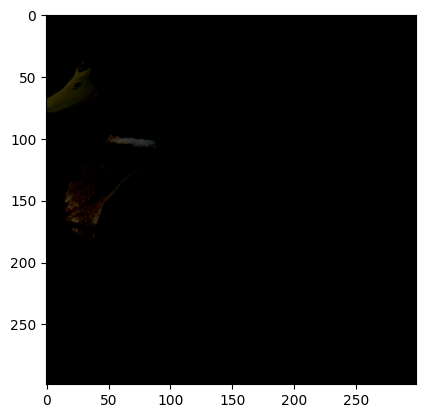

In [20]:
#Load manipulated image
from PIL import Image
ind = Image.open("Mallard_Manipulated.jpg")
img = human_tansform(ind)
X = transform(ind).unsqueeze(0)

plt.imshow(X[0].permute(1, 2, 0))

In [21]:
#Make concept dictionary



#Get ture labels 
_,NoN_Majority_C,_,_ = Non_majority_data_set.__getitem__(picturer_idx)
Majority_C,_ = Majority_dataset.__getitem__(picturer_idx)

#Find distribution of the concepts
Majority_concepts = Majority_dataset.concepts
NoN_Majority_concepts = np.array([Non_majority_data_set.concepts[y] for y in Non_majority_data_set.concepts.keys()])


Concept_dict={"Concept":concept_names,
                    "Label": NoN_Majority_C.numpy().astype(bool),
                    #"Label distribution": np.mean(NoN_Majority_concepts,axis=0)[mask],
                    "Majority Label": Majority_C.numpy().astype(bool),
                    #"Majority ditribution": np.mean(Majority_concepts,axis=0)
                      }
    


  

In [22]:
#Test NoN majority joint model
model_path = r'NoMajority_models\Joint_CKTP_resize\best_Joint_model.pth'

#Load the model
Joint_model = torch.load(model_path,map_location=torch.device('cpu'),weights_only=False)
Joint_model.eval()
Joint_model.use_sigmoid = True

#Make prediction
C_hat,Y_hat = Joint_model(X)
C_hat_probability = torch.sigmoid(C_hat)
Y_hat = torch.softmax(Y_hat,dim=1)
print(f"Predicted class: {class_names[Y_hat.argmax().item()]} true class: {class_names[Y.argmax().item()]} probability of true class: {Y_hat[0,Y.argmax()].item()}")

#Make Concept prediction and other stuff
weights = Joint_model.CtoY_model.linear.weight[Y.argmax().item()]
Concept_dict["Joint Rezise"] = np.round(C_hat_probability.detach().numpy()[0][mask],2)

Predicted class: 087.Mallard true class: 087.Mallard probability of true class: 0.011857599020004272


In [23]:
#Test NoN majority joint model
model_path = r'NoMajority_models\Joint_CKTP_NoPretraining\best_Joint_model.pth'

#Load the model
Joint_model = torch.load(model_path,map_location=torch.device('cpu'),weights_only=False)
Joint_model.eval()
Joint_model.use_sigmoid = True

#Make prediction
C_hat,Y_hat = Joint_model(X)
C_hat_probability = torch.sigmoid(C_hat)
Y_hat = torch.softmax(Y_hat,dim=1)
print(f"Predicted class: {class_names[Y_hat.argmax().item()]} true class: {class_names[Y.argmax().item()]} probability of true class: {Y_hat[0,Y.argmax()].item()}")

#Make Concept prediction and other stuff
weights = Joint_model.CtoY_model.linear.weight[Y.argmax().item()]
Concept_dict["Joint NoPretraining"] = np.round(C_hat_probability.detach().numpy()[0][mask],2)

Predicted class: 087.Mallard true class: 087.Mallard probability of true class: 0.011386179365217686


In [24]:
# Test the concept model with NoN majority voting
XtoC_Model = torch.load(r'NoMajority_models\Concepts_CKTP_Resize\best_XtoC_model.pth',map_location=torch.device('cpu'),weights_only=False)
XtoC_Model.eval()

CtoY_Model = torch.load(r'NoMajority_models\Sequential_CKTP__Resize\best_CtoY_model.pth',map_location=torch.device('cpu'),weights_only=False)
CtoY_Model.eval()
CtoY_model = CtoY_Model.float()

#Make prediction
C_hat = XtoC_Model(X)
C_hat_probability = torch.sigmoid(C_hat)

Y_hat = torch.softmax(CtoY_Model(C_hat_probability),dim=1)

print(f"Predicted class: {class_names[Y_hat.argmax().item()]} true class: {class_names[Y.argmax().item()]} probability of true class: {Y_hat[0,Y.argmax()].item()}")

#Make Concept prediction and other stuff
weights = CtoY_Model.linear.weight[Y.argmax().item()]

Concept_dict["Sequential Resize"] = np.round(C_hat_probability.detach().numpy()[0],2)
#display_scrollable_dataframe(pd.DataFrame(Concept_dict).sort_values(by=['Majority Label',"Label"],ascending=False))

Predicted class: 069.Rufous_Hummingbird true class: 087.Mallard probability of true class: 0.002156076254323125


In [25]:
XtoC_Model = torch.load(r'NoMajority_models\Concepts_CKTP_NoPretraining\best_XtoC_model.pth',map_location=torch.device('cpu'),weights_only=False)
XtoC_Model.eval()

CtoY_Model = torch.load(r'NoMajority_models\Sequential_CKTP_NoPretraining\best_CtoY_model.pth',map_location=torch.device('cpu'),weights_only=False)
CtoY_Model.eval()
CtoY_model = CtoY_Model.float()

#Make prediction
C_hat = XtoC_Model(X)
C_hat_probability = torch.sigmoid(C_hat)

Y_hat = torch.softmax(CtoY_Model(C_hat_probability),dim=1)

print(f"Predicted class: {class_names[Y_hat.argmax().item()]} true class: {class_names[Y.argmax().item()]} probability of true class: {Y_hat[0,Y.argmax()].item()}")

#Make Concept prediction and other stuff
weights = CtoY_Model.linear.weight[Y.argmax().item()]

Concept_dict["Sequential NoPretraining"] = np.round(C_hat_probability.detach().numpy()[0],2)

Predicted class: 087.Mallard true class: 087.Mallard probability of true class: 0.9999785423278809


In [27]:
Concept_dict["Label distribution"] = np.mean(NoN_Majority_concepts,axis=0)

In [37]:
Full_df=pd.DataFrame(Concept_dict)
#Selected_df = Full_df[Full_df["Label"] != Full_df["Majority Label"]]

# add row 39 to selected
selected_concepts= [239,21,54,311,145,147,179]
Selected_df = Full_df.loc[selected_concepts]

display_scrollable_dataframe(Selected_df)

,Concept,Label,Majority Label,Joint Rezise,Joint NoPretraining,Sequential Resize,Sequential NoPretraining,Label distribution
239,has_back_pattern::multi-colored,False,True,0.46,0.47,0.18,0.50,0.194774
21,has_wing_color::white,True,True,0.34,0.18,0.14,0.40,0.260774
54,has_breast_pattern::solid,False,True,0.44,0.51,0.49,0.43,0.548269
311,has_wing_pattern::multi-colored,True,True,0.51,0.62,0.23,0.62,0.297336
145,has_eye_color::black,False,True,0.77,0.72,0.84,0.84,0.837462
147,has_eye_color::red,False,False,0.04,0.05,0.02,0.01,0.023583
179,has_under_tail_color::white,False,True,0.26,0.15,0.21,0.29,0.179080


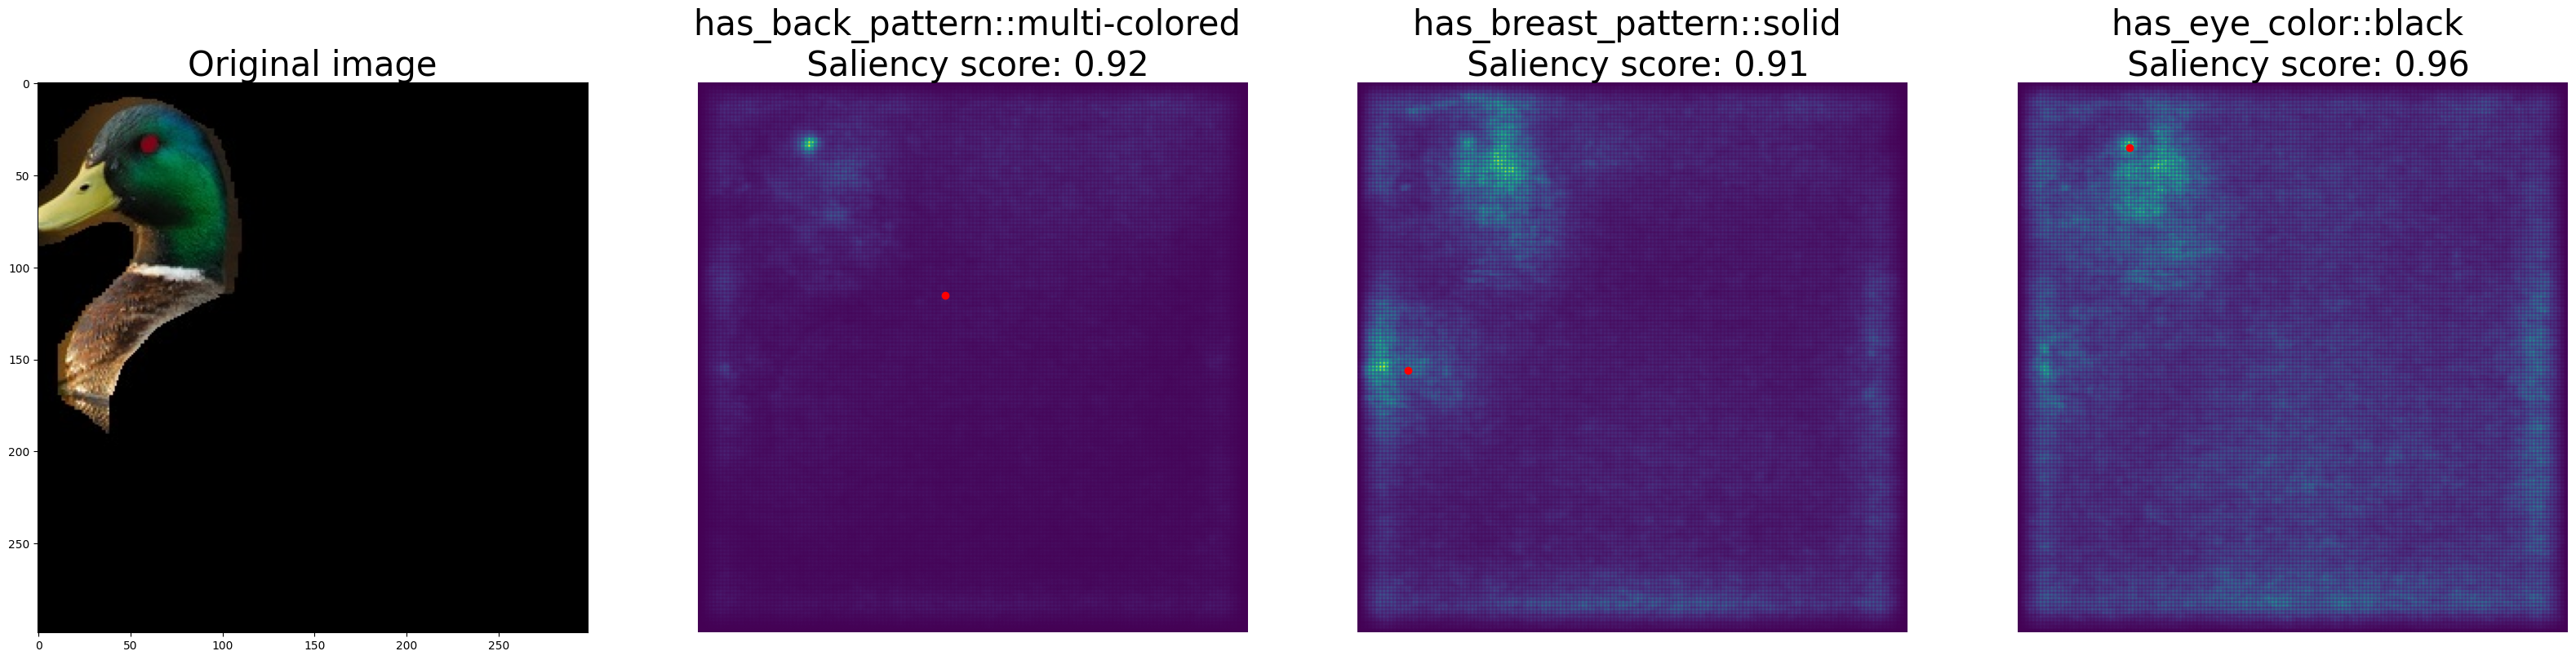

In [13]:
concept_list = [239,54,145]
XtoC_Model = torch.load(r'NoMajority_models\Concepts_CKTP_NoPretraining\best_XtoC_model.pth',map_location=torch.device('cpu'),weights_only=False)
XtoC_Model.eval()

#Make temps names
#coordinates_temp = [coordinates[i] for i in mask]
#concept_names_temp = concept_names[mask] 
sailency_maps = get_saliency_maps(X,mask[concept_list],XtoC_Model,method_type='noise_tunnel')

plot_sailency(img,sailency_maps,concept_list,concept_names,coordinates)

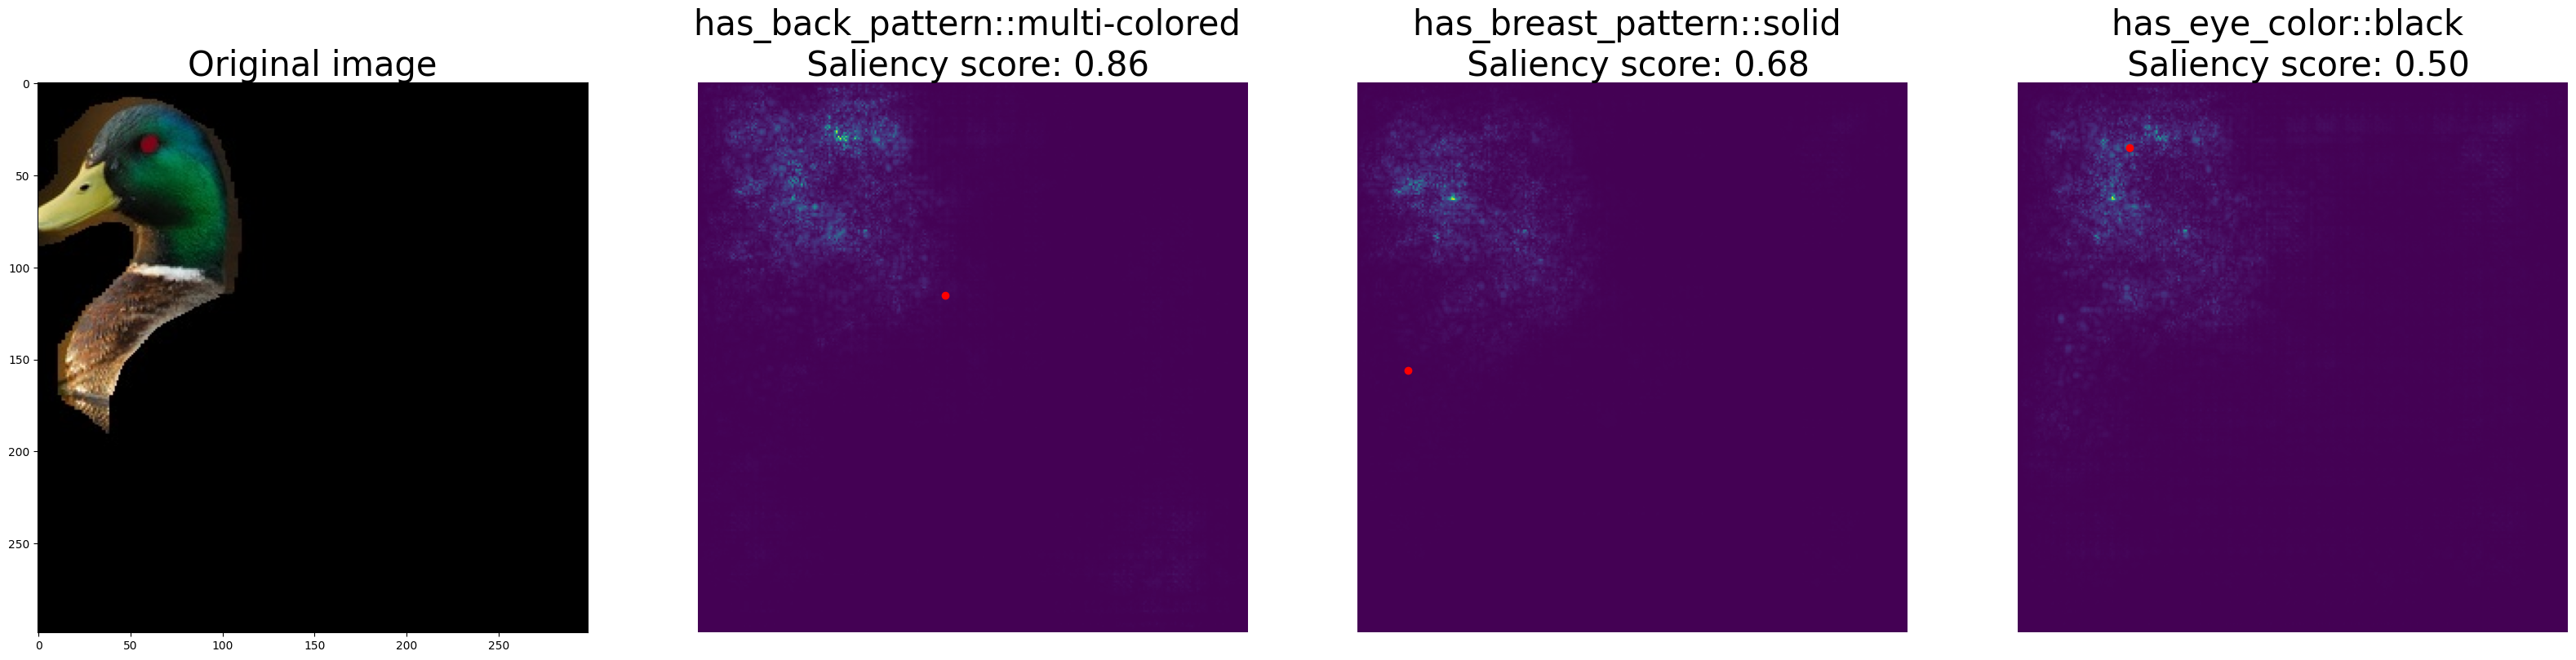

In [40]:
concept_list = [239,54,145]
XtoC_Model = torch.load(r'NoMajority_models\Concepts_CKTP_Resize\best_XtoC_model.pth',map_location=torch.device('cpu'),weights_only=False)
XtoC_Model.eval()

#Make temps names
#coordinates_temp = [coordinates[i] for i in mask]
#concept_names_temp = concept_names[mask] 
sailency_maps = get_saliency_maps(X,mask[concept_list],XtoC_Model,method_type='vanilla')

plot_sailency(img,sailency_maps,concept_list,concept_names,coordinates)

In [38]:
#print full df
display_scrollable_dataframe(Full_df)

,Concept,Label,Majority Label,Joint Rezise,Joint NoPretraining,Sequential Resize,Sequential NoPretraining,Label distribution
0,has_bill_shape::curved_(up_or_down),False,False,0.05,0.01,0.04,0.01,0.021971
1,has_bill_shape::dagger,False,False,0.11,0.06,0.15,0.02,0.134968
2,has_bill_shape::hooked,False,False,0.03,0.01,0.02,0.00,0.015948
3,has_bill_shape::needle,False,False,0.11,0.06,0.25,0.03,0.024516
4,has_bill_shape::hooked_seabird,False,False,0.18,0.17,0.08,0.20,0.063709
5,has_bill_shape::spatulate,True,True,0.43,0.56,0.02,0.79,0.039786
6,has_bill_shape::all-purpose,False,False,0.17,0.10,0.25,0.10,0.391754
7,has_bill_shape::cone,False,False,0.14,0.03,0.17,0.01,0.261452
8,has_bill_shape::specialized,False,False,0.03,0.08,0.02,0.02,0.021293
9,has_wing_color::blue,False,False,0.35,0.29,0.04,0.20,0.050051


In [34]:
print(Selected_df.to_latex(index=False, float_format=lambda x: '{:.2f}'.format(x)))

\begin{tabular}{lrrrrrrr}
\toprule
Concept & Label & Majority Label & Joint Rezise & Joint NoPretraining & Sequential Resize & Sequential NoPretraining & Label distribution \\
\midrule
has_back_pattern::multi-colored & False & True & 0.46 & 0.47 & 0.18 & 0.50 & 0.19 \\
has_wing_color::white & True & True & 0.34 & 0.18 & 0.14 & 0.40 & 0.26 \\
has_breast_pattern::solid & False & True & 0.44 & 0.51 & 0.49 & 0.43 & 0.55 \\
has_wing_pattern::multi-colored & True & True & 0.51 & 0.62 & 0.23 & 0.62 & 0.30 \\
has_eye_color::black & False & True & 0.77 & 0.72 & 0.84 & 0.84 & 0.84 \\
has_eye_color::red & False & False & 0.04 & 0.05 & 0.02 & 0.01 & 0.02 \\
\bottomrule
\end{tabular}



In [17]:
display_scrollable_dataframe(Full_df.sort_values(by=['Majority Label',"Label"],ascending=False))

,Concept,Label,Majority Label,Joint Rezise,Joint NoPretraining,Sequential Resize,Sequential NoPretraining,Label distribution
5,has_bill_shape::spatulate,True,True,0.43,0.56,0.02,0.79,0.039786
21,has_wing_color::white,True,True,0.34,0.18,0.14,0.40,0.260774
36,has_upperparts_color::white,True,True,0.31,0.16,0.10,0.37,0.232949
38,has_upperparts_color::buff,True,True,0.11,0.25,0.08,0.41,0.169410
40,has_underparts_color::brown,True,True,0.17,0.23,0.12,0.48,0.102732
90,has_upper_tail_color::black,True,True,0.44,0.29,0.11,0.21,0.256956
101,has_head_pattern::plain,True,True,0.58,0.41,0.24,0.66,0.263828
106,has_breast_color::brown,True,True,0.22,0.47,0.12,0.67,0.113590
149,has_bill_length::about_the_same_as_head,True,True,0.53,0.67,0.41,0.61,0.362233
220,has_size::medium_(9_-_16_in),True,True,0.52,0.68,0.15,0.81,0.196386


In [18]:
df=pd.DataFrame(Concept_dict).sort_values(by=['Majority Label',"Label"],ascending=False)
latex_table = df.to_latex(index=False)
print(latex_table)

\begin{tabular}{lrrrrrrr}
\toprule
Concept & Label & Majority Label & Joint Rezise & Joint NoPretraining & Sequential Resize & Sequential NoPretraining & Label distribution \\
\midrule
has_bill_shape::spatulate & True & True & 0.430000 & 0.560000 & 0.020000 & 0.790000 & 0.039786 \\
has_wing_color::white & True & True & 0.340000 & 0.180000 & 0.140000 & 0.400000 & 0.260774 \\
has_upperparts_color::white & True & True & 0.310000 & 0.160000 & 0.100000 & 0.370000 & 0.232949 \\
has_upperparts_color::buff & True & True & 0.110000 & 0.250000 & 0.080000 & 0.410000 & 0.169410 \\
has_underparts_color::brown & True & True & 0.170000 & 0.230000 & 0.120000 & 0.480000 & 0.102732 \\
has_upper_tail_color::black & True & True & 0.440000 & 0.290000 & 0.110000 & 0.210000 & 0.256956 \\
has_head_pattern::plain & True & True & 0.580000 & 0.410000 & 0.240000 & 0.660000 & 0.263828 \\
has_breast_color::brown & True & True & 0.220000 & 0.470000 & 0.120000 & 0.670000 & 0.113590 \\
has_bill_length::about_the_same_